# Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_people = pd.read_csv(".data/people_wiki.csv")
df_people.columns = ["URI","name","text"]
df_people.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [3]:
df_people_train = df_people.loc[~df_people["name"].str.contains("Barack Obama"),:]
df_people_test = df_people.loc[df_people["name"].str.contains("Barack Obama"),:] # We do this because we want to use the text at the end to see how it works on the new data.



In [4]:
from nltk.corpus import stopwords
#nltk.download("stopwords") #only once and first of all download the stopwrods
stopwords_en = stopwords.words("english")
print(stopwords_en[:5])

['i', 'me', 'my', 'myself', 'we']


# Data cleaning

In [5]:
# Now we do a lemmatisation 
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from time import time

tokenizer = RegexpTokenizer(r'[a-zA-Z][a-zA-Z][a-zA-Z]+') # three letters minimum
#nltk.download("stopwords") #only once and first of all download stopwords
stopwords_en = stopwords.words("english")
print(stopwords_en[:5])
lemmatizer = WordNetLemmatizer()

def clean(text):
    tokens = [lemmatizer.lemmatize(token) for token in tokenizer.tokenize(text) if token not in stopwords_en]
    return " ".join(tokens)

['i', 'me', 'my', 'myself', 'we']


In [6]:
start = time()
df_people_train["clean_text"] = df_people_train["text"].map(clean)
print("Time {:0.3f}s.".format(time() - start))

Time 18.892s.


C:\Users\caos_\AppData\Local\Temp\ipykernel_17896\3780997061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_people_train["clean_text"] = df_people_train["text"].map(clean)


In [7]:
# LDA only works with the bag of words, exactly with the bag of words and how many times each term appears, for that you have to use sklearn's CountVectorizer.
from sklearn.feature_extraction.text import CountVectorizer

c_vect = CountVectorizer(max_features=5000)
people_data = c_vect.fit_transform(df_people_train["clean_text"])
terms = c_vect.get_feature_names_out()
print(terms)

['aaa' 'aaron' 'aba' ... 'zimbabwe' 'zone' 'zurich']


## Fit the model

In [8]:
from sklearn.decomposition import LatentDirichletAllocation

#Number of topics
n_topics = 20 

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20, learning_method="online",
                                learning_offset=50. , random_state=0, n_jobs=-1) 

#n_components: This is the number of topics you want to split the dataset into. 
#max_iter: Represents the maximum number of iterations the algorithm will perform on the data.
#lerning_method online updates parameters incrementally using subsets of the data, which is useful for large volumes of data. 
#n_jobs -1 is to use all available processors.

In [9]:
start = time()
document_topic = lda.fit_transform(people_data)
topic_term = lda.components_
print("Time {:0.3f}s".format(time()-start))

Time 260.506s


In [10]:
print("Model size: ", topic_term.shape)
print("Size of the transformation result:  ", document_topic.shape)

Model size:  (20, 5000)
Size of the transformation result:   (42785, 20)


# Model study

In [11]:
def topic_relevant_words(model,terms, topic_id, num_words):
    print("Group ", topic_id)
    print("----------------------")
    #Extracts the positions of the highest scores
    top_term_ids = model[topic_id,:].argsort()[:-num_words-1:-1]
    #Extracts the terms from the corresponding positions
    top_terms = [terms[id_term] for id_term in top_term_ids]
    #Extract and calculate probabilities
    top_probabilities = model [topic_id, top_term_ids] / np.sum(model[topic_id,:])
    #Print the results
    for term, probability in zip(top_terms,top_probabilities):
        print("{:s}:           \t{:.4f}".format(term,probability))
    print("-------------------------")
    
    
topic_relevant_words(topic_term, terms, 0, 10)

Group  0
----------------------
club:           	0.0261
season:           	0.0214
league:           	0.0199
played:           	0.0192
team:           	0.0138
football:           	0.0133
first:           	0.0126
cup:           	0.0123
made:           	0.0102
goal:           	0.0101
-------------------------


In [12]:
    
topic_relevant_words(topic_term, terms, 3, 10)

Group  3
----------------------
art:           	0.0617
work:           	0.0286
museum:           	0.0214
new:           	0.0207
artist:           	0.0206
race:           	0.0176
design:           	0.0163
gallery:           	0.0137
york:           	0.0124
exhibition:           	0.0116
-------------------------


In [13]:
character_id = 130
print("Character: ", df_people_train.iloc[character_id]['name'])
print("Composition of the document: ")
print(document_topic[character_id,:])
print()

topics = document_topic[character_id,:].argsort()[:-3:-1]
for id_topic in topics:
    topic_relevant_words(topic_term, terms, id_topic,  10)

Character:  Moana Jackson
Composition of the document: 
[0.04199604 0.08536826 0.21566592 0.00051546 0.0272428  0.00051546
 0.00051546 0.00051546 0.00051546 0.00051546 0.06064702 0.12102704
 0.00051546 0.09364466 0.10690916 0.00051546 0.00051546 0.24182898
 0.00051546 0.00051546]

Group  17
----------------------
law:           	0.0403
state:           	0.0336
court:           	0.0202
district:           	0.0178
new:           	0.0143
served:           	0.0138
united:           	0.0130
county:           	0.0124
house:           	0.0122
judge:           	0.0119
-------------------------
Group  2
----------------------
force:           	0.0085
year:           	0.0081
war:           	0.0074
air:           	0.0069
right:           	0.0066
military:           	0.0066
police:           	0.0064
born:           	0.0061
state:           	0.0058
one:           	0.0055
-------------------------


Text(0, 0.5, 'Score')

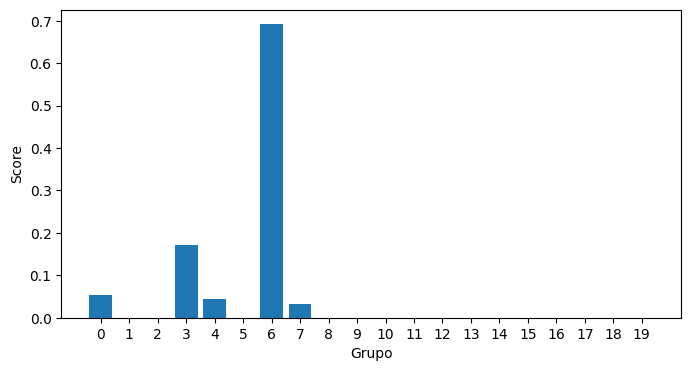

In [14]:
# AND FERNANDO ALONSO WHERE WOULD HE BE?
id_alo = df_people_train.index[df_people_train["name"].str.contains("Fernando Alonso")][0]
# Gets the position (needed to access the array)
pos_alo = df_people_train.index.get_loc(id_alo)

#Graphics
plt.figure(figsize=(8,4))
plt.bar(range(n_topics), document_topic[pos_alo,:])
plt.xticks(range(n_topics))
plt.xlabel("Grupo")
plt.ylabel("Score")

# NEW DATA

barack hussein obama ii brk husen bm born august 4 1961 is the 44th and current president of the united states and the first african american to hold the office born in honolulu hawaii obama is a graduate of columbia university and harvard law school where he served as president of the harvard law review he was a community organizer in chicago before earning his law degree he worked as a civil rights attorney and taught constitutional law at the university of chicago law school from 1992 to 2004 he served three terms representing the 13th district in the illinois senate from 1997 to 2004 running unsuccessfully for the united states house of representatives in 2000in 2004 obama received national attention during his campaign to represent illinois in the united states senate with his victory in the march democratic party primary his keynote address at the democratic national convention in july and his election to the senate in november he began his presidential campaign in 2007 and after

C:\Users\caos_\AppData\Local\Temp\ipykernel_17896\1699110821.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  text_char = df_people_test[df_people["name"].str.contains("Barack Obama")].iloc[0].text


Text(0, 0.5, 'Score')

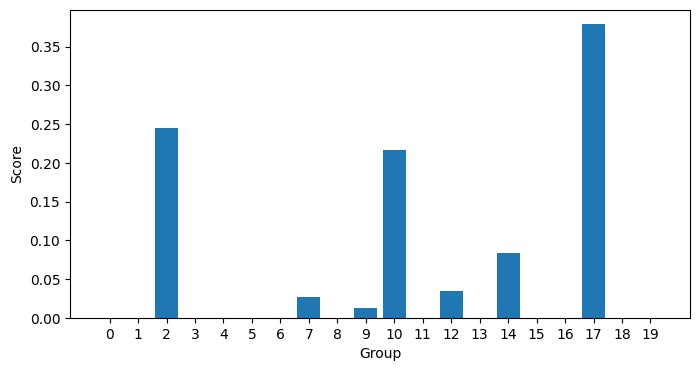

In [16]:
# Extract the text
text_char = df_people_test[df_people["name"].str.contains("Barack Obama")].iloc[0].text
print(text_char)
#Clean text
text_char = clean(text_char)
#Vectorize 
vec_per = c_vect.transform([text_char])
#catalogues
topic_per = lda.transform(vec_per)

#plot the figure
plt.figure(figsize=(8,4))
plt.bar(range(n_topics), topic_per[0])
plt.xticks(range(n_topics))
plt.xlabel('Group')
plt.ylabel('Score')

In [17]:
topic_relevant_words(topic_term, terms, 17, 10)

Group  17
----------------------
law:           	0.0403
state:           	0.0336
court:           	0.0202
district:           	0.0178
new:           	0.0143
served:           	0.0138
united:           	0.0130
county:           	0.0124
house:           	0.0122
judge:           	0.0119
-------------------------
